# Lyrics to genres multi-label classification

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import random

from gensim.models import KeyedVectors
import numpy as np
import tensorflow as tf
import keras.backend as tfb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, MaxPooling1D, Dropout, Conv1D, LSTM, Bidirectional, SpatialDropout1D, Flatten
import keras.backend as tfb
from keras.utils.generic_utils import get_custom_objects
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
POS_WEIGHT = 6  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor
    and a target tensor. POS_WEIGHT is used as a multiplier
    for the positive targets.
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    target = tf.cast(target, tf.float32)
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)


get_custom_objects().update({"weighted_binary_crossentropy": weighted_binary_crossentropy})


def f1_score(y_true, y_logit):
    """
    Calculate F1 score
    y_true: true value
    y_logit: predicted value
    """
    true_positives = tfb.sum(tfb.round(tfb.clip(y_true * y_logit, 0, 1)))
    possible_positives = tfb.sum(tfb.round(tfb.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tfb.epsilon())
    predicted_positives = tfb.sum(tfb.round(tfb.clip(y_logit, 0, 1)))
    precision = true_positives / (predicted_positives + tfb.epsilon())
    return (2 * precision * recall) / (precision + recall + tfb.epsilon())


def set_labels(x):
    labels = np.array([0 for i in range(len(unique_genres))])

    for item in x.split(","):
        labels[list(unique_genres).index(item)] = 1
    
    return np.array(labels)


def csv_to_train_val_data(path:str, split_rate = 0.15):
    # read data
    data = pd.read_csv(path)

    # fix data
    data["genre"] = data["genre"].apply(lambda x: x.replace("\n"," "))
    data["labels"] = data["genre"].apply(lambda x: set_labels(x))

    # data splitting
    x_train, x_test, y_train, y_test = train_test_split(data["lyrics"], data["labels"], test_size=split_rate, shuffle=True)

    y_train = np.stack(y_train.values).astype('float32')
    y_test = np.stack(y_test.values).astype('float32')

    # tokenize data
    tokenizer = Tokenizer(lower=True, num_words=max_words)
    tokenizer.fit_on_texts(list(x_train) + list(x_test))

    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)

    x_train = pad_sequences(x_train, maxlen=maxlen)
    x_test = pad_sequences(x_test, maxlen=maxlen)

    print(f'X train shape: {x_train.shape}')
    print(f'X test shape: {x_test.shape}')
    print(f'Y train shape: {y_train.shape}')
    print(f'Y test shape: {y_test.shape}')

    return x_train, x_test, y_train, y_test, tokenizer


def visualise_history(hist):
    measures = ['loss', 'accuracy', 'f1_score']

    fig, ax = plt.subplots(3, figsize= (12,12))
    
    for i, measure in enumerate(measures):
        val_measure = 'val_' + measure
        ax[i].plot(hist.history[measure], label=measure)
        ax[i].set_title(measure)
        ax[i].plot(hist.history[val_measure], label=val_measure)
        ax[i].set_title(val_measure)
        ax[i].legend()
        ax[i].set_ylabel(measure)
    plt.xlabel('epochs')
    plt.show()
    

def run_model(model_name, batch_size=64, epochs=5, optimizer='adam', loss='weighted_binary_crossentropy', verbose=1):
    model = models_dict[model_name]
    model.compile(optimizer=optimizer, 
            loss=loss, 
            metrics=[f1_score, "accuracy", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=verbose)
    
    return hist, model
        

def create_confusion_matrix(model, threshold=0.5):
    y_pred = model.predict(x_test)

    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0

    return multilabel_confusion_matrix(y_test, y_pred)


def calculate_confusion_ratio(matrix):
    ok = sum([matrix[i, 0, 0] + matrix[i, 1, 1] for i in range(matrix.shape[0])])
    bad = sum([matrix[i, 1, 0] + matrix[i, 0, 1] for i in range(matrix.shape[0])])
    
    print(f"percent of ok: {ok/(ok+bad)*100}%")
    
    return ok/(ok+bad)*100
    
    
def get_new_genres(df):
    genres = dict()
    
    for row in df.genre:
        for item in row.split(","):
            if item in genres:
                genres[item] += 1
            else:
                genres[item] = 1
    return genres

    
def plot_hist(df):
    genres = get_new_genres(df)

    plt.figure(dpi=250)
    plt.bar(genres.keys(), genres.values())
    plt.title("Number of genre occurances")
    plt.ylabel ('Number of occurances')
    plt.xlabel ('Genre')
    plt.xticks(list(genres.keys()), rotation=75, fontsize=3)
    plt.show()
    
    
def clean_text(text):
    text = text.lower()
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def remove_punctuation(text): 
    text = re.sub(r'[?|!|\'|"|#]', r'',text)
    text = re.sub(r'[.|,|)|(|\|/]', r' ',text)
    text = text.strip()
    text = text.replace("\n"," ")
    return text

def remove_numbers(text):
    result = ""
    
    for word in text.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        result += alpha_word
        result += " "
    result = result.strip()
    
    return result

def ultimate_text_cleaning(text):
    text = clean_text(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text


def save_hist(hist, hist_filename):
    hist_df = pd.DataFrame(hist.history) 

    hist_csv_file = r"model_logging/" + hist_filename + r".csv"

    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

def save_results(model, results_filename):
    matrix = create_confusion_matrix(model, threshold=0.5)
    result = calculate_confusion_ratio(matrix)
    
    result_file = r"model_logging/" + results_filename + r".txt"

    with open(result_file, mode='w') as f:
        f.write(str(result))
        f.write("\n\n")
        f.write(str(matrix))

### LOAD DATA

In [19]:
# data_path = r'data_cleaned/data_12labels_mulitlabel_lyrics_cleaned.csv'
data_path = r'data_cleaned/data_12labels_mulitlabel_lyrics_cleaned2.csv'

data = pd.read_csv(data_path)
# data["lyrics"] = data["lyrics"].apply(lambda x: ultimate_text_cleaning(x))

unique_genres = set()

for row in data.genre:
    for item in row.split(","):
        unique_genres.add(item)

num_classes = len(unique_genres)
print(f"num_classes: {num_classes}")

num_classes: 11


In [20]:
# data.to_csv(r'data_cleaned/data_12labels_mulitlabel_lyrics_cleaned2.csv', index=False)

In [21]:
print(f"Lenght of data: {len(data.index)}")

Lenght of data: 145305


In [22]:
data.head()

,artist,track,genre,lyrics,lyrics_len,nb_of_genres
0,The Chameleons,Nostalgia,punk,absorbing your words battles raging within me ...,192,1
1,The Cheetah Girls,One World,"experimental,pop",ch ch ch ch ka ch ch ch ch ka hey ch ch ch ch ...,157,2
2,Michael Kiwanuka,Tell Me a Tale,r&b,tell me a tale that always was sing me a song ...,196,1
3,Three Days Grace,Sign of the Times,"metal,rock",this is a sign of the times another mountain t...,193,2
4,La Roux,In for the Kill,"electronic,pop",we can fight our desires but when we start mak...,196,2


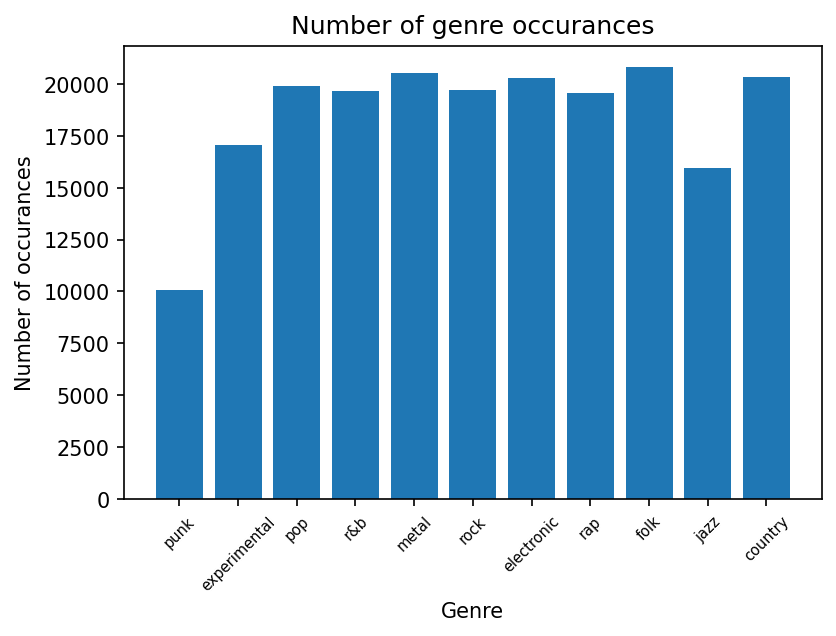

In [23]:
genres = get_new_genres(data)

plt.figure(dpi=150)
plt.bar(genres.keys(), genres.values())
plt.title("Number of genre occurances")
plt.ylabel('Number of occurances')
plt.xlabel('Genre')
plt.xticks(list(genres.keys()), rotation=45, fontsize=7)
plt.show()

### STARTING PARAMETERS

In [27]:
max_words = 50_000
maxlen = 200
embedding_dim = 300

### Prepare dataset

In [28]:
x_train, x_test, y_train, y_test, tokenizer = csv_to_train_val_data(path=data_path, split_rate=0.1)

X train shape: (130774, 200)
X test shape: (14531, 200)
Y train shape: (130774, 11)
Y test shape: (14531, 11)


### FASTTEXT LOAD

In [29]:
embedding_pretrained = [r"pretrained_embeddings/wiki-news-300d-1M.vec", 
                        r"pretrained_embeddings/wiki-news-300d-1M-subword.vec", 
                        r"pretrained_embeddings/crawl-300d-2M.vec", 
                        r"pretrained_embeddings/crawl-300d-2M-subword.vec"]

fasttext = KeyedVectors.load_word2vec_format(embedding_pretrained[3], binary=False, encoding='utf8')


### EMBEDDING

In [34]:

vocab_size = len(tokenizer.word_index) + 1
nb_of_unknown_words = 0

weight_matrix = np.zeros((vocab_size, embedding_dim))
words_unknown = dict()

for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = fasttext[word]
        weight_matrix[i] = embedding_vector
    except KeyError:
        if word in words_unknown.keys():
            weight_matrix[i] = words_unknown[word]
        else:
            words_unknown[word] = np.random.uniform(-5, 5, embedding_dim)
            weight_matrix[i] = words_unknown[word]
            nb_of_unknown_words += 1
        
print(f"Number of unknown words inizialized randomly: {nb_of_unknown_words}")   

Number of unknown words inizialized randomly: 71971


### Check GPU availability

In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### DECLARE MODELS IN DICTIONARY

In [39]:
models_dict = { 
    # "cnn1": Sequential([
    #                 Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
    #                 SpatialDropout1D(0.2),
    #                 Conv1D(input_shape=(maxlen, embedding_dim), filters=64, kernel_size=3, activation='tanh', kernel_regularizer='l1_l2'),
    #                 MaxPooling1D(),
    #                 Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_regularizer='l1_l2'),
    #                 MaxPooling1D(),
    #                 Flatten(),
    #                 Dropout(0.3),
    #                 Dense(100, activation='tanh', kernel_regularizer='l1_l2'),
    #                 Dropout(0.3),
    #                 Dense(num_classes, activation="sigmoid")
    #                 ]),
    # "cnn2": Sequential([
    #                 Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
    #                 Conv1D(input_shape=(maxlen, embedding_dim), filters=32, kernel_size=3, activation='tanh', kernel_regularizer='l1_l2'),
    #                 MaxPooling1D(),
    #                 Conv1D(filters=64, kernel_size=3, activation='tanh', kernel_regularizer='l1_l2'),
    #                 MaxPooling1D(),
    #                 Conv1D(filters=128, kernel_size=3, activation='tanh', kernel_regularizer='l1_l2'),
    #                 MaxPooling1D(),
    #                 Flatten(),
    #                 Dropout(0.3),
    #                 Dense(100, kernel_regularizer='l1_l2', activation='tanh'),
    #                 Dropout(0.3),
    #                 Dense(num_classes, activation="sigmoid")
    #                 ]),
    "lstm1": Sequential([
                    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
                    Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Dropout(0.3),
                    GlobalMaxPool1D(),
                    Dense(num_classes, activation="sigmoid")
                    ]),
    "lstm2": Sequential([
                    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
                    Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Dropout(0.3),
                    GlobalMaxPool1D(),
                    Dense(num_classes, activation="sigmoid")
                    ]),
    "lstm3": Sequential([
                    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
                    Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Dropout(0.3),
                    GlobalMaxPool1D(),
                    Dense(num_classes, activation="sigmoid")
                    ]),
    "lstm4": Sequential([
                    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
                    Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Dropout(0.3),
                    GlobalMaxPool1D(),
                    Dense(num_classes, activation="sigmoid")
                    ]),
    "lstm5": Sequential([
                    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
                    Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Dropout(0.3),
                    GlobalMaxPool1D(),
                    Dense(50, activation="relu", kernel_regularizer="l1_l2"),
                    Dropout(0.1),
                    Dense(num_classes, activation="sigmoid")
                    ]),
    "lstm6": Sequential([
                    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[weight_matrix], trainable=False),
                    Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', 
                                        recurrent_dropout=0.0, dropout=0.3, kernel_initializer='glorot_uniform'),
                                    merge_mode='concat'),
                    Dropout(0.3),
                    GlobalMaxPool1D(),
                    Dense(50, activation="relu", kernel_regularizer="l1_l2"),
                    Dropout(0.1),
                    Dense(num_classes, activation="sigmoid")
                    ])
}

### RUNNING THE NETS

In [40]:
for m in models_dict.keys():
    print(f"\n\nNow calculation model: {m}...\n\n")
    
    hist, model = run_model(m, batch_size=64, epochs=30, 
                            optimizer="adam", loss="weighted_binary_crossentropy", verbose=1)
    
    model_filename = r"models/" + m + r".h5"
    model.save(model_filename)
    
    save_hist(hist, m)
    save_results(model, m)
    visualise_history(hist)
    



Now calculation model: lstm1...


Epoch 1/30
 666/2044 [========>.....................] - ETA: 38s - loss: 1.0763 - f1_score: 0.2731 - accuracy: 0.2149 - auc: 0.6378

### Save/Load

In [ ]:
# curr_model.save(r'models/lstm_fasttext_1.h5')

In [ ]:
# new_model = tf.keras.models.load_model(r'models/lstm_fasttext_1.h5')

### Check

In [ ]:
matrix = create_confusion_matrix(model, threshold=0.5)

In [ ]:
calculate_confusion_ratio(matrix)

In [ ]:
y_pred = model.predict(x_test)

In [26]:
unique_genres = set()

for row in data.genre:
    for item in row.split(","):
        unique_genres.add(item)

for k in random.sample(range(0, len(x_test)), 100):
  indexes_pred = np.argwhere(y_pred[k] >= 0.5)
  indexes_true = np.argwhere(y_test[k] == 1)

  indexes_pred.reshape((1,-1))
  indexes_true.reshape((1,-1))

  for i in indexes_pred:
    print(list(unique_genres)[i[0]])

  print(y_pred[k])
  print("\n")

  for i in indexes_true:
    print(list(unique_genres)[i[0]])

  print(y_test[k])

NameError: name 'y_pred' is not defined